# Interacting with ONETEP via ASE (& Jupyter Notebooks)

## Nicholas Hine
## University of Warwick
## ONETEP Masterclass 2024

# Jupyter Notebook

## What is Jupyter?

Project Jupyter exists to develop open-source software, open-standards, and services for interactive computing across dozens of programming languages.

The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning, and much more.


https://jupyter.org/

# Jupyter Notebooks: Basic Features



In [13]:
# Basic arithmetic
a=3
b=2
c=a+b
print('c =',c)

c = 5


In [14]:
# Functions
def f(x):
    return x**2
print('f(c) =',f(c))

f(c) = 25


In [15]:
# Symbolic mathematics (requires a package eg sympy, sage)
from sympy import Eq, var, init_printing, solve
init_printing(); var('a:z')
eq = Eq(a*x**2+b*x+c,0)
display(eq); display(solve(eq,x))

# Jupyter Notebooks: Basic Features



In [40]:
# Graph plotting
import matplotlib.pyplot as plt
%matplotlib notebook 
import numpy as np
x=np.linspace(0,2*np.pi,200)
a=1
plt.figure()
plt.plot(x,np.sin(a*x))
plt.show()

<IPython.core.display.Javascript object>

# Atomic Simulation Environment
## What is ASE?

The [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/about.html) is a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations. The code is freely available under the GNU LGPL license.

https://wiki.fysik.dtu.dk/ase/

Jupyter and ASE make an excellent combination for setting up, visualising, and analysing the results of atomistic simulations.

# Atomic Simulation Environment

ASE provides interfaces to different codes through [Calculators](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html#module-ase.calculators) which are used together with the central [Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) object and the many available algorithms in ASE.

<img src="https://warwick.ac.uk/fac/sci/physics/staff/academic/nicholashine/ase_results.png" alt="ASE Results" width="600" />


# Atomic Simulation Environment

ASE has a range of built-in tools to create model systems

In [42]:
# Set up a water molecule
from ase.build import molecule
wat = molecule('H2O')
benz = molecule('C6H6')

In [43]:
# Create a water-benzene complex 
cplx = wat + benz

How can we see what we have made?

# Atomic Simulation Environment

ASE has [tools to visualize Atoms](https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html?highlight=viewers) models, and several available 'viewers'. The default behaviour is to create a pop-up window (via the ASE-GUI) but this is not ideal in a notebook, where a better is viewer='ngl' (requires installation of the nglview python package).

In [44]:
from ase.visualize import view
view(wat,viewer='ngl')

# Atomic Simulation Environment

If we look at our combined model of water + benzene, we discover it has both molecules on top of each other! This is probably not what we intended.

We also set ball-and-stick mode for the visualization here

In [24]:
v=view(cplx,viewer='ngl')
v.view.add_ball_and_stick()
v

# Atomic Simulation Environment

We can use ASE routines, part of the Atoms type, to translate and rotate the water to an appropriate position for the water-benzene complex

In [25]:
def myview(atoms):
    v=view(atoms,viewer='ngl')
    v.view.add_ball_and_stick()
    return v
wat2 = wat.copy()
wat2.translate([0,0,3.3]) # distances in angstrom
wat2.rotate(180,'x') # angles in degrees
cplx2 = wat2 + benz
myview(cplx2)

# Surfaces and interfaces

There are many tools for creating crystals, surfaces, nanostructures, interfaces etc.

In [26]:
# Create some structures: 4x4x4 supercell of Copper, [111] slab of fcc-Al, Graphene nanoribbon
from ase.build import bulk, fcc111, graphene_nanoribbon
Cu_444 = bulk('Cu', 'fcc', a=3.6)*(4,4,4)
Al_slab = fcc111('Al', size=(2,2,3), vacuum=10.0)
GNR = graphene_nanoribbon(3,4,type='armchair',saturated=True,vacuum=3.5)

# View them all in a GridBox widget
from ase.visualize import ngl; from ipywidgets import GridBox, Layout
v1 = ngl.view_ngl(Cu_444, w=400, h=250).view
v2 = ngl.view_ngl(Al_slab, w=400, h=250).view
v3 = ngl.view_ngl(GNR, w=400, h=250).view
b = GridBox(children=[v1,v2,v3],layout=Layout(width='90%',grid_template_columns='33% 33% 33%')); b

GridBox(children=(NGLWidget(), NGLWidget(), NGLWidget()), layout=Layout(grid_template_columns='33% 33% 33%', w…

# Fancy Visualizations

IPython Widgets are very powerful: a small amount of code can produce helpful design tools

In [27]:
from ipywidgets import interact
from ase.build import mx2; import numpy as np

import numpy as np
def f(m,n,theta):
    MoS2_nn = mx2('MoS2', a=3.18,thickness=5,vacuum=5,size=(m, n, 1))
    MoS2_nn.rotate(theta,'z',rotate_cell=False)
    print(len(MoS2_nn),' atoms')
    return ngl.view_ngl(MoS2_nn, w=400, h=250).view
interact(f,n=(1,10,1),m=(1,10,1),theta=(0.0,60.0,1.0));

interactive(children=(IntSlider(value=5, description='m', max=10, min=1), IntSlider(value=5, description='n', …

## Adding a Calculator

Once you have designed a model, you will want to calculate its properties! For this we need to attach a Calculator.

In [38]:
from ase.calculators.onetep import Onetep, OnetepProfile
from os import environ

profile = OnetepProfile(
    command="/home/theory/phspvr/jup_ase_tut/launch_onetep.sh",
    pseudo_path="/home/theory/phspvr/onetep/pseudo"
)

cplx2.center(6) # Choose a unit cell (6 Ang of padding around the molecule)

# Create the Calculator
calc = Onetep(keywords = {"task": 'SINGLEPOINT', 
                          "do_properties": True,
                          "popn_calculate": False,
                          "write_forces": True,
                          "cutoff_energy": '600 eV'},
              ngwf_count={"C": 4, "O": 4, "H": 1},
              ngwf_radius={"C": 8.0, "O": 8.0, "H": 8.0},
              pseudopotentials={"C": "carbon.recpot", "O": "oxygen.recpot", "H": "hydrogen.recpot"},
              profile=profile,
              directory="cplx2")

cplx2.calc = calc # Associate the calculator with the Atoms object of the complex

In [39]:

print('Total energy = ',cplx2.get_potential_energy()) # Calculate and print total energy
# We could also set this up to send to a queue locally or remotely
# or to just write the appropriate input file and run the calculation manually

Total energy =  -1499.425272063008


In [46]:
cplx2.calc.results

{'energy': -1499.425272063008,
 'free_energy': -1499.425272063008,
 'natoms': 15,
 'forces': array([[ 0.        ,  0.        , -0.74152171],
        [-0.        , -0.66731997,  0.44497083],
        [-0.        ,  0.66731997,  0.44497083],
        [-0.        , -0.1011338 , -0.03040411],
        [-0.36291686, -0.74588852, -0.01576153],
        [-0.36291686,  0.74588852, -0.01576153],
        [-0.        ,  0.1011338 , -0.03040411],
        [ 0.36291686,  0.74588852, -0.01576153],
        [ 0.36291686, -0.74588852, -0.01576153],
        [-0.        , -0.33884081,  0.00564466],
        [-0.03719497, -0.08231674, -0.00896398],
        [-0.03719497,  0.08231674, -0.00896398],
        [ 0.        ,  0.33884081,  0.00564466],
        [ 0.03719497,  0.08231674, -0.00896398],
        [ 0.03719497, -0.08231674, -0.00896398]])}

## Analysing the results

In [47]:
# We can view the forces (in eV/ang)
calc.get_forces()

array([[ 0.        ,  0.        , -0.74152171],
       [-0.        , -0.66731997,  0.44497083],
       [-0.        ,  0.66731997,  0.44497083],
       [-0.        , -0.1011338 , -0.03040411],
       [-0.36291686, -0.74588852, -0.01576153],
       [-0.36291686,  0.74588852, -0.01576153],
       [-0.        ,  0.1011338 , -0.03040411],
       [ 0.36291686,  0.74588852, -0.01576153],
       [ 0.36291686, -0.74588852, -0.01576153],
       [-0.        , -0.33884081,  0.00564466],
       [-0.03719497, -0.08231674, -0.00896398],
       [-0.03719497,  0.08231674, -0.00896398],
       [ 0.        ,  0.33884081,  0.00564466],
       [ 0.03719497,  0.08231674, -0.00896398],
       [ 0.03719497, -0.08231674, -0.00896398]])

## Analysing the results

<IPython.core.display.Javascript object>


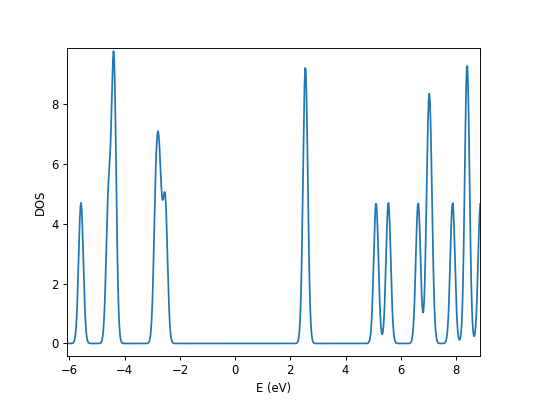

In [50]:
# We can load and plot outputs such as as the density of states
data = np.loadtxt("cplx2_DOS.txt")
e_pt = data[:,0]; DOS = data[:,1]
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.plot(e_pt,DOS); plt.xlabel("E (eV)"); plt.ylabel("DOS")
plt.show()

# Tagging Atoms

## To analyse subsystems, use tags to create different species

In [ ]:
# We could ask for LDOS on different elements... 
# but H is in both subsystems so we need to tag them
wat3  = wat2.copy();  tags = wat3.get_tags();  tags = 1; wat3.set_tags(tags)
benz3 = benz.copy(); tags = benz3.get_tags(); tags = 2; benz3.set_tags(tags)

calc = Onetep(label='cplx2') # re-use same label as before to enable continuation
keywords_with_ldos = keywords.copy()
keywords_with_ldos["task"] = "Properties"
keywords_with_ldos["species_ldos_groups"] = (('O1','H1'),('C2','H2'))

cplx3 = wat3 + benz3; cplx3.center(6); cplx3.calc = calc
calc.calculate()

In [ ]:
# TO DO: emphasise separation of Atoms and Cell types
#        Note possibility to transfer calculations between codes easily
#

# Advanced Model Building

In [52]:
# Import modules
from ase.lattice.hexagonal import *
from ase.calculators.onetep import Onetep

# Set up a graphene lattice with a 9x9 supercell
index1=9; index2=9; alat = 2.45; clat = 31.85
gra = Graphene(symbol = 'C',latticeconstant={'a':alat,'c':clat},size=(index1,index2,1))

# find atom near centre of cell to make impurity
sym = gra.get_chemical_symbols(); j = 80; sym[j] = 'N'; gra.set_chemical_symbols(sym)

# define radii for up to 5th nearest neighbour atoms and tag appropriately
tags = gra.get_tags()
tags[j] = -1 # exclude impurity
shell_rad = [1.5,2.5,3.0,4.0,4.5]
for k in range(len(shell_rad)):
    tags = [ k+1 if ((gra.get_distance(i,j)<shell_rad[k]) and
                     (tags[i]==0)) else tags[i] for i in range(len(gra)) ]
tags[j] = 0 # reset impurity tag
gra.set_tags(tags)

# Advanced Model Building

In [54]:
v=view(gra,viewer='ngl'); v

# Summary

## ASE and Jupyter are a powerful combination

* ASE Interfaces enables you to write computational protocols that are highly
  - reproducible (publish script alongside paper)
  - adaptable / reusable (make functions that can be looped over for different materials)
  - verifiable (store protocols under version control repositories to share/publish)
  - validatable (run same system with different codes)

# Summary

## ONETEP ASE Calculator

* Current version written by Ed Tait and Nicholas Hine circa 2017 - used old format of FileIOCalculator
* New version, rewritten from scratch by Tom Demeyere, is awaiting integration with ASE
  - large changes under the hood, but not that much difference from user perspective (will update this example notebook once it is the default)

In [58]:
from ase.io import read

atoms=read("cplx2/onetep.out")

In [59]:
view(atoms,viewer='ngl')